In [150]:
from preprocessing import read_data,data_with_sparse_matrix,process_data
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import gensim
import warnings
import torch
import re
import underthesea
warnings.filterwarnings('ignore')
from string import punctuation
punctuation = punctuation + '‘’“”'


In [151]:
dat1 = read_data('Dataset_For_Work\\1-VLSP2018-SA-Hotel-train (7-3-2018).txt')
dat2 = read_data('Dataset_For_Work\\2-VLSP2018-SA-Hotel-dev (7-3-2018).txt')
dat3 = read_data('Dataset_For_Work\\3-VLSP2018-SA-Hotel-test (8-3-2018).txt')

In [152]:
dat1

,review,sentiment
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,"{HOTEL#DESIGN&FEATURES, positive}, {HOTEL#GENE..."
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...","{LOCATION#GENERAL, positive}"
2,"Phục vụ, view đẹp, vị trí","{SERVICE#GENERAL, positive}, {HOTEL#GENERAL, p..."
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng","{HOTEL#COMFORT, positive}, {HOTEL#CLEANLINESS,..."
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,"{LOCATION#GENERAL, positive}, {FACILITIES#GENE..."
...,...,...
2995,Đối diện thung lũng Một kỳ nghỉ tuyệt vời ở Sa...,"{HOTEL#COMFORT, positive}, {SERVICE#GENERAL, p..."
2996,Cảm nhận của cá nhân về Sapa View: Phòng ốc đẹ...,"{ROOMS#DESIGN&FEATURES, positive}, {ROOMS#CLEA..."
2997,"Xin chào Chudu24,Xin cám ơn dịch vụ booking củ...","{ROOMS#CLEANLINESS, positive}, {ROOMS#COMFORT,..."
2998,"Đầu tiên về ưu điểm:- Phòng sạch sẽ, nội thất ...","{ROOMS#CLEANLINESS, positive}, {ROOM_AMENITIES..."


In [154]:
final_dat1,new_dat1 = data_with_sparse_matrix(dat1)
final_dat2,new_dat2 = data_with_sparse_matrix(dat2)
final_dat3,new_dat3 = data_with_sparse_matrix(dat3)

In [ ]:
final_dat1.head(10)

In [ ]:
final_dat1.Text.values

In [71]:
#clean_dat1 = pd.read_csv(clean_dat1.csv)

In [155]:
def process_data(data):
    sentences = []
    stop_words = open('Dataset_For_Work\\vietnamese-stopwords.txt','r',encoding='utf-8').read().split('\n')
    for item in data:
        processed_item = item.lower()
        # for s_t in stop_words:

        #     processed_item = re.sub(rf" {s_t} ", ' ', processed_item)

        processed_item = re.sub(f'[{punctuation}]',' ',processed_item)
        processed_item = re.sub(f'\s+',' ',processed_item)
        temp = underthesea.sent_tokenize(processed_item)
        sentences += temp

    tokenize_data = [underthesea.word_tokenize(i) for i in sentences]

    return tokenize_data, sentences

In [156]:
token1,sentences1 = process_data(final_dat1.Text.values)
token2,sentences2 = process_data(final_dat2.Text.values)    
token3,sentences3 = process_data(final_dat3.Text.values)

In [ ]:
# clean_dat1

In [168]:
def process_data2(data):
    data_doc = []
    stop_words = open('Dataset_For_Work\\vietnamese-stopwords.txt','r',encoding='utf-8').read().split('\n')
    for item in data:
        processed_item = item.lower()
        # for s_t in stop_words:
        #     processed_item = re.sub(rf" {s_t} ", ' ', processed_item)
        processed_item = re.sub(f'[{punctuation}]',' ',processed_item)
        processed_item = re.sub(f'\s+',' ',processed_item)
        temp = underthesea.sent_tokenize(processed_item)
        tokenize_data = []
        for i in temp:
          tokenize_data += underthesea.word_tokenize(i)
        data_doc.append(tokenize_data)
    return data_doc

In [169]:
process_dat1 = process_data2(final_dat1.Text.values)
process_dat2 = process_data2(final_dat2.Text.values)
process_dat3 = process_data2(final_dat3.Text.values)

In [172]:
def convert_data_to_vector(data,model,max_length):

    vector_data = []
    for item in data:
        temp = []
        print(item)
        for word in item:
            try:
                temp.append(model.wv.get_vector(word))
            except KeyError:
                print(word)
                print('Từ này không có trong từ điển :))')
                continue
        
        # Padding câu để đồng nhất kích thước của vector, phục vụ cho quá trình train
        while len(temp) < max_length:
            temp.append(np.zeros(model.wv.vector_size))  # Thêm vector 0
        
        # Cắt bớt nếu câu dài hơn max_length
        temp = temp[:max_length]
        
        vector_data.append(np.array(temp))
    
    # Chuyển embedding vector sang Tensor
    vector_data = np.array(vector_data) 
    return torch.tensor(vector_data, dtype=torch.float32) # (batch_size, max_length, embedding_dim)


#Tensor chứa list các vector câu 
#Kích thước cảu Tensor là (số lượng câu,kích thước của 1 câu,số chiều của vector embedding)
#Ví dụ có câu #Tôi đi học
#Tensor có dạng
#[[vector tôi],[vector đi],[vector học]]

In [173]:
MAX_LENGTH = 150

In [174]:
w2v_model = gensim.models.Word2Vec(sentences=token1 + token2 + token3,
                               min_count=1,
                               vector_size=128,
                               alpha=0.001,
                               window=5,
                               epochs=5000,
                               )

In [131]:
from torch.utils.data import DataLoader, TensorDataset

In [175]:
# Chuyển đổi x_train và x_test sang vector rồi padding
x_train_vector = convert_data_to_vector(data=process_dat1, model=w2v_model, max_length=MAX_LENGTH)
x_test_vector = convert_data_to_vector(data=process_dat2, model=w2v_model, max_length=MAX_LENGTH)
#Chuyển nhãn từ -1 -> 0 , 0->1 , 1->2 để dùng softmax
y_train = np.array(final_dat1.Label.values, dtype=np.int64)+1
y_test = np.array(final_dat2.Label.values, dtype=np.int64)+1

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_vector, y_train)
test_dataset = TensorDataset(x_test_vector, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#Batch size là số lượng mẫu dữ liệu được xử lý cùng lúc trong 1 lần huấn luyện
#Ví dụ 300 mẫu dữ liệu thì nó sẽ tác động 128 mẫu đầu / batch
#rồi tiếp tục cho đến khi áp dụng phần dư còn lại nốt tính là 1 batch nữa

['rộng rãi', 'ks', 'mới', 'nhưng', 'rất', 'vắng', 'các', 'dịch vụ', 'chất lượng', 'chưa', 'cao', 'và', 'thiếu']
['địa điểm', 'thuận tiện', 'trong', 'vòng', 'bán kính', '1', '5', 'km', 'nhiều', 'quán', 'ăn', 'ngon']
['phục vụ', 'view', 'đẹp', 'vị trí']
['thuận tiện', 'sạch sẽ', 'vui vẻ', 'hài lòng']
['vị trí', 'đẹp', 'có', 'quán', 'bar', 'view', 'đẹp', 'nhân viên', 'thân thiện']
['co', 'view', 'huong', 'ho', 'tay', 'sach', 'se', 'nhan vien', 'tan tinh']
['phòng ốc', 'sạch', 'giường', 'thoải mái', 'nhân viên', 'thân thiện']
['gần', 'hồ', 'tây view', 'nhìn', 'ra', 'hồ', 'lãng mạn', 'đi', 'bộ', 'dọc', 'hồ', 'tây', 'ăn', 'các', 'món', 'hà nội', 'phòng', 'sạch', 'đẹp', 'tiện nghi', 'có', 'view', 'nhìn', 'ra', 'hồ tây', 'rất', 'tuyệt phí', 'thuê', 'xe', 'ô tô', 'của', 'khách sạn', 'đi', 'yên tử', 'chùa', 'hương', 'giá cáo', 'hơn', 'bên', 'ngoài', 'khá', 'nhiều']
['hình thức', 'không thể', 'quyết định', 'nội dung', 'h', 'atildey', 'đến', 'để', 'tận hưởng', 'cảm nhận', 'với', 'tôi', 'tuyệt vời'

In [178]:
w2v_model.wv.most_similar('có')

[('và', 0.8387399911880493),
 ('được', 0.7931689620018005),
 ('phòng', 0.790724515914917),
 ('rất', 0.7760816216468811),
 ('ở', 0.7716262340545654),
 ('không', 0.7687219977378845),
 ('là', 0.7516400814056396),
 ('thì', 0.7438615560531616),
 ('khách sạn', 0.7362029552459717),
 ('nên', 0.7192195057868958)]

In [179]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentCNNLSTM(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=None, num_layers=1, num_filters=128, filter_sizes=[2, 3, 4], num_classes=3, dropout_rate=0.5):
        super(SentimentCNNLSTM, self).__init__()
        
        # Convolutional layers với BatchNorm và ReLU
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=input_dim, 
                          out_channels=num_filters, 
                          kernel_size=fs),
                nn.BatchNorm1d(num_filters),
                nn.ReLU()
            )
            for fs in filter_sizes
        ])
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=len(filter_sizes) * num_filters, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        self.fc = nn.Linear(2 * hidden_dim, num_classes)  # Bidirectional nên 2 * hidden_dim

    def forward(self, x):
        # Đầu vào: (batch_size, sequence_length, embedding_dim)
        # Đổi chiều thành: (batch_size, embedding_dim, sequence_length)
        x = x.permute(0, 2, 1)
        
        # Áp dụng convolution và global max pooling
        conv_results = []
        for conv in self.convs:
            conved = conv(x)  # (batch_size, num_filters, new_seq_length)
            pooled = F.max_pool1d(conved, kernel_size=conved.shape[2]).squeeze(2)  # (batch_size, num_filters)
            conv_results.append(pooled)
        
        # Nối kết quả từ các filters lại thành 1 tensor
        x = torch.cat(conv_results, dim=1)  # (batch_size, len(filter_sizes) * num_filters)
        
        # Thêm chiều sequence_length=1 để phù hợp đầu vào LSTM
        x = x.unsqueeze(1)  # (batch_size, 1, len(filter_sizes) * num_filters)
        
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length=1, 2*hidden_dim)
        lstm_out = lstm_out[:, -1, :]  # Lấy output cuối cùng (batch_size, 2*hidden_dim)
        
        # Dropout
        x = self.dropout(lstm_out)
        
        # Fully connected layer
        logits = self.fc(x)
        
        return logits


# Khởi tạo mô hình
input_dim = x_train_vector.shape[2]  # Số chiều embedding (embedding_dim)
hidden_dim = 128  # Kích thước hidden state của LSTM
num_layers = 1  # Số layer LSTM
num_filters = 128  # Số lượng filters cho CNN
filter_sizes = [2, 3, 4]  # Kích thước các filters
num_classes = 3  # Số lớp đầu ra
dropout_rate = 0.5  # Tỉ lệ dropout

# Khởi tạo mô hình SentimentCNNLSTM
model = SentimentCNNLSTM(
    input_dim=input_dim, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers,
    num_filters=num_filters, 
    filter_sizes=filter_sizes, 
    num_classes=num_classes,
    dropout_rate=dropout_rate
)

# Chọn hàm loss và optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss cho bài toán phân loại nhiều lớp
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adam optimizer với weight decay


In [137]:
from tqdm.autonotebook import tqdm

Chỉ cần chạy file model.pth để test model

Epoch [1/1000], Loss: 0.8174
Epoch [2/1000], Loss: 0.6469
Epoch [3/1000], Loss: 0.5423
Epoch [4/1000], Loss: 0.4567
Epoch [5/1000], Loss: 0.3759
Epoch [6/1000], Loss: 0.3245
Epoch [7/1000], Loss: 0.2444
Epoch [8/1000], Loss: 0.2010
Epoch [9/1000], Loss: 0.1449
Epoch [10/1000], Loss: 0.1213
Epoch [11/1000], Loss: 0.0784
Epoch [12/1000], Loss: 0.0559
Epoch [13/1000], Loss: 0.0379
Epoch [14/1000], Loss: 0.0280
Epoch [15/1000], Loss: 0.0211
Epoch [16/1000], Loss: 0.0183
Epoch [17/1000], Loss: 0.0146
Epoch [18/1000], Loss: 0.0108
Epoch [19/1000], Loss: 0.0091
Epoch [20/1000], Loss: 0.0124
Epoch [21/1000], Loss: 0.0090
Epoch [22/1000], Loss: 0.0068
Epoch [23/1000], Loss: 0.0090
Epoch [24/1000], Loss: 0.0053
Epoch [25/1000], Loss: 0.0043
Epoch [26/1000], Loss: 0.0051
Epoch [27/1000], Loss: 0.0037
Epoch [28/1000], Loss: 0.0030
Epoch [29/1000], Loss: 0.0031
Epoch [30/1000], Loss: 0.0047
Epoch [31/1000], Loss: 0.0043
Epoch [32/1000], Loss: 0.0092
Epoch [33/1000], Loss: 0.0087
Epoch [34/1000], Lo

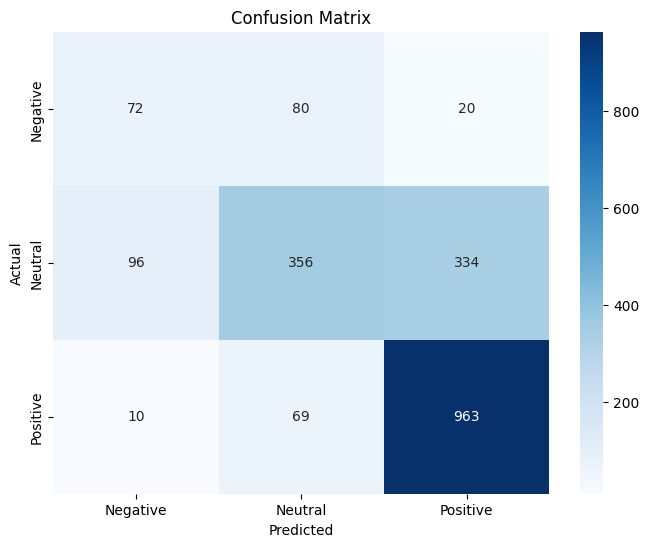

In [180]:
# from sklearn.metrics import accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Tham số huấn luyện
# num_epochs = 1000

# # Vòng lặp huấn luyện
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
    
#     for x_batch, y_batch in train_loader:
#         optimizer.zero_grad()  # Reset gradient
#         outputs = model(x_batch)  # Forward pass
#         loss = criterion(outputs, y_batch)  # Tính loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Cập nhật trọng số
        
#         total_loss += loss.item()
    
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# # Đánh giá mô hình trên tập test
# model.eval()  # Chuyển mô hình sang chế độ đánh giá
# y_true = []
# y_pred = []

# with torch.no_grad():  # Không tính gradient khi test
#     for x_batch, y_batch in test_loader:
#         outputs = model(x_batch)  # Forward pass
#         _, predicted = torch.max(outputs, 1)  # Lấy chỉ số của lớp có xác suất cao nhất
        
#         y_true.extend(y_batch.cpu().numpy())  # Ghi lại nhãn thực tế
#         y_pred.extend(predicted.cpu().numpy())  # Ghi lại nhãn dự đoán

# # Tính Accuracy
# accuracy = accuracy_score(y_true, y_pred)
# print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# # Tính Confusion Matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Hiển thị Confusion Matrix bằng Seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [181]:
# import torch

# torch.save(model.state_dict(), 'model.pth')  # Lưu model với tên file 'model.pth'



Model has been saved successfully!


Model has been loaded successfully!

Test Accuracy: 69.55%


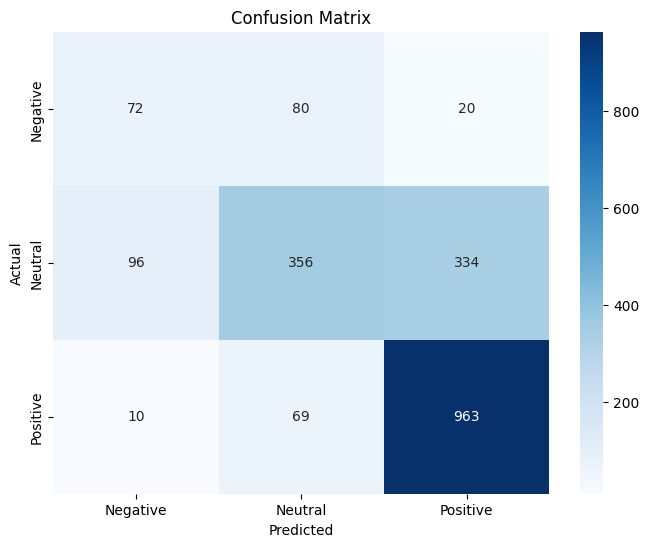


Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.42      0.41       172
     Neutral       0.70      0.45      0.55       786
    Positive       0.73      0.92      0.82      1042

    accuracy                           0.70      2000
   macro avg       0.61      0.60      0.59      2000
weighted avg       0.69      0.70      0.68      2000



In [183]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


model.load_state_dict(torch.load('model.pth'))
model.eval()  

print("Model has been loaded successfully!")

model.eval() 
y_true = []
y_pred = []

with torch.no_grad(): 
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)  
        _, predicted = torch.max(outputs, 1) 
    
        y_true.extend(y_batch.cpu().numpy())  
        y_pred.extend(predicted.cpu().numpy()) 

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
class_report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print("\nClassification Report:")
print(class_report)

In [147]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os


def clear():
    os.system('clear')

y_pred = []
checkpoint = "mr4/phobert-base-vi-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
phobert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
clear()
for input_text in final_dat2.Text:
    raw_inputs = [input_text]
    # Tokenize dữ liệu đầu vào
    inputs = tokenizer(raw_inputs, padding=True,
                    truncation=True, return_tensors="pt")
    # Dự đoán
    outputs = phobert_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    dict_label = {'Trung tính' : 1,'Tiêu cực':0,'Tích cực':2}
    # Tìm class có xác suất lớn nhất
    clear()
    for i, prediction in enumerate(predictions):
        predicted_label_idx = torch.argmax(prediction).item()  # Lấy chỉ số của giá trị lớn nhất
        predicted_label = phobert_model.config.id2label[predicted_label_idx] #Lấy tên class
        y_pred.append(dict_label[predicted_label])



Test Accuracy: 64.25%


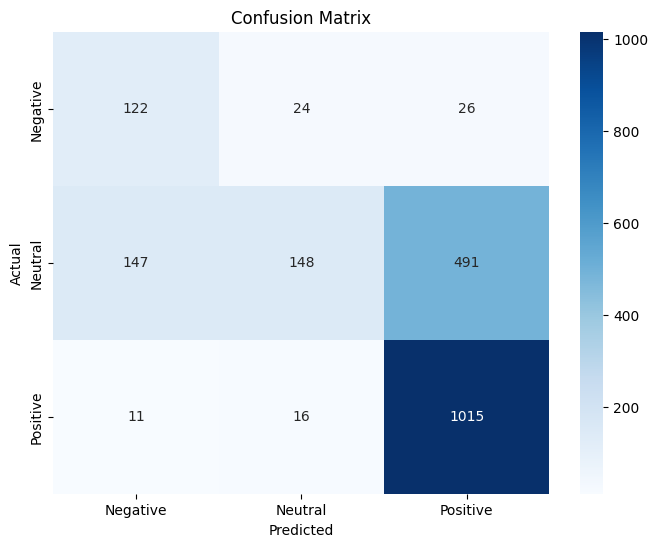

In [149]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()